<h2>Importing Libraries</h2>

In [1]:
# Importing necessary libraries
import tensorflow as tf  # TensorFlow library for deep learning
import keras  # Keras high-level neural networks API
from keras import layers  # Keras layers for building neural network models
import numpy as np  # NumPy library for numerical computations
import matplotlib.pyplot as plt  # Matplotlib library for plotting
import cv2  # OpenCV library for image processing
import os  # Operating system module for file operations
from tqdm import tqdm  # tqdm library for progress bars
import re  # Regular expressions module for string processing
from keras.preprocessing.image import img_to_array  # Convert images to NumPy arrays
import time  # Time module for measuring execution time

2024-04-19 16:17:44.795618: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 16:17:44.795728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 16:17:44.955100: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<h2>Defining the constants</h2>

In [ ]:
#  Define the image size
SIZE = 128
_img = []
# Path to the image dataset
path= '../input/face-mask-lite-dataset/without_mask/'
# Path to save model checkpoints
checkpoint_dir = '/kaggle/working/training_checkpoints/'
# Path for saving final model
model_save_dir = '/kaggle/working/models/'
# List all the files in the directory
files = os.listdir(path)
# Define batch size
batch_size = 32
# Dimension of the latent space
latent_dim = 100

<h2>Managing the files, to store the images in an array</h2>

In [2]:
def sorted_alphanumeric(data):
    """
    Sorts a list of the string alphanumerically.

    Args:
        data (list): List of the strings tobe sorted.

    Returns:
        list: Alphanumerically sorted list of strings.
    """
    
    # Checks if the string is a number and converts it to integer for sorting
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    # Split the string into a list of string and numbers
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    # Returns the sorted list of strings
    return sorted(data, key=alphanum_key)

In [ ]:
# Listing all the files in the alphanumerically sorted order
files = sorted_alphanumeric(files)

In [3]:
# Iterate through files with a progress bar
for i in tqdm(files):
    # Read image using OpenCV
    img = cv2.imread(path+'/'+i, 1)  # 1 for color image
    # Convert image from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize image to specified dimensions
    img = cv2.resize(img, (SIZE, SIZE))
    # Normalize pixel values to range [-1, 1]
    img = (img - 127.5) / 127.5
    # Convert image to float datatype
    imh = img.astype(float)
    # Convert image to array and append to list
    _img.append(img_to_array(img))

100%|██████████| 10000/10000 [09:48<00:00, 17.01it/s]


<h2>Displaying sample input data</h2>

/tmp/ipykernel_34/2366208009.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(sqr, sqr, i+1)


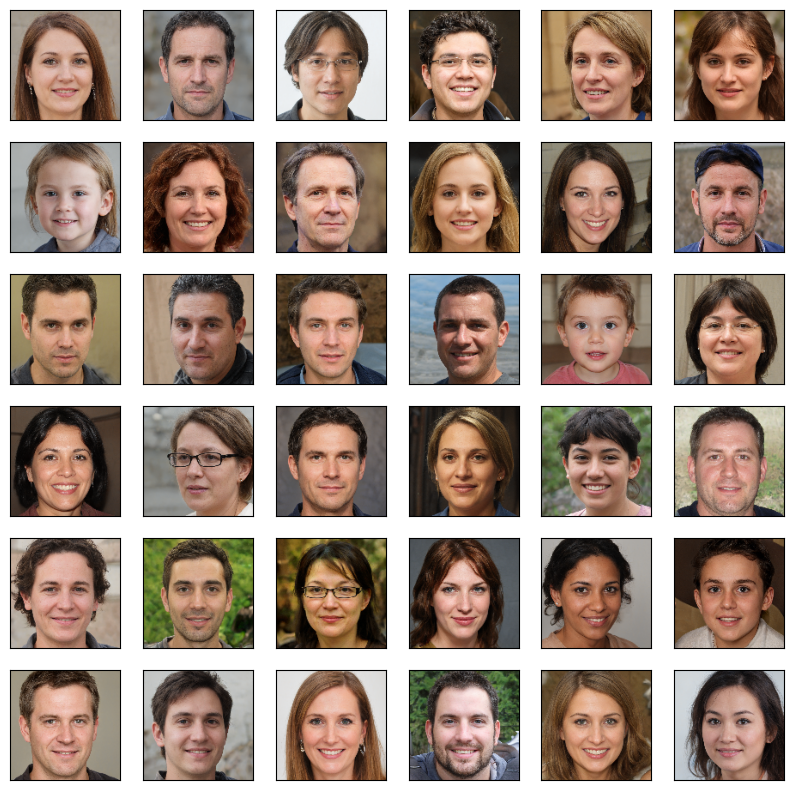

In [4]:
def plot_images(sqr=5):
    """
    Plot images from _img list.

    Args:
        sqr (int): Number of images per row/column in the plot grid. Default is 5.
    """
    # Create a new figure with a specified size
    plt.figure(figsize=(10, 10))
    # Set the title of the plot
    plt.title("Real Images")
    
    # Iterate through each subplot
    for i in range(sqr*sqr):
        # Create a subplot in the grid
        plt.subplot(sqr, sqr, i+1)
        # Display an image in the subplot, adjusting pixel values to range [0, 1]
        plt.imshow(_img[i]*0.5 + 0.5)
        # Remove x-axis ticks
        plt.xticks([])
        # Remove y-axis ticks
        plt.yticks([])

# Call the function to plot images in a grid with 6 images per row/column
plot_images(6)

<h2>Creating dataset by help of the tensorflow dataset</h2>

In [5]:
# Create a TensorFlow dataset from the _img list
# tf.data.Dataset.from_tensor_slices creates a dataset with one element for each row of the input tensor
# np.array(_img) converts the _img list into a numpy array
# .batch() batch the dataset into smaller batches
dataset = tf.data.Dataset.from_tensor_slices(np.array(_img)).batch(batch_size)

<h2>Building up the structure of the GAN (Generative Adversarial Networks) model</h2>

<h4>Defining the structure of the generator</h4>

In [6]:
def Generator():
    # Define a sequential model
    model = tf.keras.Sequential()
    
    # Add a fully connected layer with no bias, mapping from latent space to 128*128*3 dimensions
    model.add(keras.layers.Dense(128*128*3, use_bias=False, input_shape=(latent_dim, )))
    # Reshape the output to a 128x128x3 image tensor
    model.add(keras.layers.Reshape((128, 128, 3)))
    
    # Downsampling layers
    # Convolutional layers with LeakyReLU activation and batch normalization
    model.add(keras.layers.Conv2D(128, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    
    # More convolutional layers with LeakyReLU activation and batch normalization
    model.add(keras.layers.Conv2D(256, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    
    # Upsampling layers
    # Transposed convolutional layers with LeakyReLU activation and batch normalization
    model.add(keras.layers.Conv2DTranspose(512, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.LeakyReLU())
    
    # More transposed convolutional layers with LeakyReLU activation and batch normalization
    model.add(keras.layers.Conv2DTranspose(512, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.Conv2DTranspose(512, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Conv2DTranspose(256, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.Conv2DTranspose(256, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    
    # Final convolutional layers to generate the output image
    model.add(keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.Conv2DTranspose(256, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2DTranspose(3, 4, strides=1, padding='same', activation='tanh'))
    
    return model

<h4>Creating a instance of the generator and printing out the summary of the generator</h4>

In [7]:
# Creates a generator model
generator = Generator()

# Prints a summary of the generator model
generator.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 49152)          │     4,915,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 128)  │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       262,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 256)    │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │     1,048,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 512)    │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 512)    │     4,194,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 512)    │     4,194,304 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 512)    │     4,194,304 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 256)    │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 256)    │     1,048,576 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 25,648,643 (97.84 MB)

 Trainable params: 25,645,827 (97.83 MB)

 Non-trainable params: 2,816 (11.00 KB)

<h4>Defining the structure of the discriminator</h4>

In [8]:
def Discriminator():
    # Create a sequential model for the discriminator
    model = keras.models.Sequential()
    
    # Input layer specifying the size of input images
    model.add(keras.layers.Input((SIZE, SIZE, 3)))
    
    # Convolutional layer with 128 filters, 4x4 kernel size, and 2x2 stride
    model.add(keras.layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.BatchNormalization())  # Batch normalization for stable training
    model.add(keras.layers.LeakyReLU())  # LeakyReLU activation for introducing non-linearity
    
    # More convolutional layers with similar configurations
    model.add(keras.layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
              
    model.add(keras.layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    
    model.add(keras.layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
              
    model.add(keras.layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.LeakyReLU())
    
    # Flatten the output to feed into a dense layer
    model.add(keras.layers.Flatten())
    
    # Final dense layer with sigmoid activation, outputting a single value (0 or 1) for binary classification
    model.add(keras.layers.Dense(1, activation='sigmoid'))
              
    return model

<h4>Creating a instance of the generator and printing out the summary of the discriminator</h4>

In [9]:
# Create an instance of the discriminator model
discriminator = Discriminator()

# Print a summary of the discriminator model
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │       262,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 256)      │     1,048,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 512)      │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,949,569 (15.07 MB)

 Trainable params: 3,948,033 (15.06 MB)

 Non-trainable params: 1,536 (6.00 KB)

<h2>Plotting noise generated image by generator before training<h2>

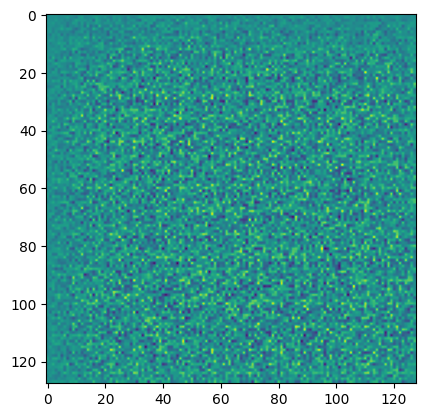

In [10]:
# Generate random noise using NumPy
noise = np.random.normal(-1, 1, (1, 100))  # Shape: (1, 100)

# Generate an image using the generator model
img = generator(noise)  # Pass the noise through the generator model to generate an image

# Display the generated image
plt.imshow(img[0, :, :, 0])  # Show the first channel of the generated image (assuming it's a grayscale image)
plt.show()

<h2>Defining loss function and optimizer</h2>

In [11]:
# Define the RMSprop optimizer for the generator model
optimizer = keras.optimizers.RMSprop(
    learning_rate=0.0001,  # Learning rate for the optimizer
    clipvalue=1.0,          # Clip gradients to a maximum of 1.0 to prevent exploding gradients
    decay=1e-8              # Decay rate to prevent the learning rate from getting too small
)

# Define the RMSprop optimizer for the discriminator model
optimizer1 = keras.optimizers.RMSprop(
    learning_rate=0.0001,  # Learning rate for the optimizer
    clipvalue=1.0,          # Clip gradients to a maximum of 1.0 to prevent exploding gradients
    decay=1e-8              # Decay rate to prevent the learning rate from getting too small
)

# Define the binary cross-entropy loss function for training the models
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


<h4>Defining custom functions for managing the generator and discriminator loss</h4>

In [12]:
def generator_loss(fake_output):
    """
    Computes the loss for the generator.

    Args:
        fake_output: Output of the discriminator when given generated images.

    Returns:
        The generator loss value.
    """
    # Use binary cross-entropy loss to measure the difference between the discriminator's output and ones (real labels)
    return cross_entropy(tf.ones_like(fake_output), fake_output)


def discriminator_loss(fake_output, real_output):
    """
    Computes the loss for the discriminator.

    Args:
        fake_output: Output of the discriminator when given generated images.
        real_output: Output of the discriminator when given real images.

    Returns:
        The discriminator loss value.
    """
    # Compute the loss for fake images by comparing the discriminator's output with zeros (fake labels)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    # Compute the loss for real images by comparing the discriminator's output with ones (real labels)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    
    # The total discriminator loss is the sum of the losses for fake and real images
    return fake_loss + real_loss


<h2>Defining the training steps functions for gradient stepping and loss back propagation</h2>

In [13]:
def train_steps(images):
    # Generate random noise for the generator input
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    
    # Use GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate images using the generator
        generated_images = generator(noise)
        
        # Get discriminator outputs for generated and real images
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)
        
        # Calculate generator and discriminator losses
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)
    
    # Compute gradients of generator and discriminator losses with respect to trainable variables
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    # Apply gradients to update the generator and discriminator parameters using their respective optimizers
    optimizer.apply_gradients(zip(gradient_of_generator, generator.trainable_variables))
    optimizer1.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))
    
    # Return the computed losses for monitoring
    loss = {'gen loss': gen_loss,
            'disc loss': dis_loss}
    return loss

<h2>Function for generaring new images from normal distribution having mean 0 and standard deviation 1 and ploting generated images</h2>

In [26]:
def plot_generated_images(square=5, epochs=0):
    """
    Plot generated images using the trained generator model.

    Args:
        square (int): Number of images per row/column in the plot grid. Default is 5.
        epochs (int): Current epoch number for display in the plot title. Default is 0.
    """
    # Create a new figure for plotting
    plt.figure(figsize=(10, 10))
    
    # Iterate through each subplot in the grid
    for i in range(square*square):
        # Add a title to the plot if the epoch number is provided and it's the middle subplot
        if epochs != 0:
            if(i == square//2):
                plt.title("Generated images at Epoch: {}\n".format(epochs))
        
        # Create random noise for generating an image
        noise = np.random.normal(0, 1, (1, latent_dim))
        
        # Generate an image using the generator model
        img = generator(noise)
        
        # Clip pixel values to [0, 1] range and plot the image
        plt.imshow(np.clip((img[0, ...]+1)/2, 0, 1))
        
        # Remove x-axis ticks
        plt.xticks([])
        # Remove y-axis ticks
        plt.yticks([])
        # Display grid lines for visual clarity
        plt.grid()


<h2>Defining the outer function for training  of GAN (generator and discriminator)</h2>

In [20]:
def train(epochs, dataset, checkpoint_dir):
    """
    Train the GAN model for a specified number of epochs using the given dataset.

    Args:
        epochs (int): Number of epochs for training.
        dataset (tf.data.Dataset): Input dataset for training.
        checkpoint_dir (str): Directory to save checkpoints.

    Returns:
        dict: History of generator and discriminator losses during training.
    """
    # Lists to store generator and discriminator losses for each epoch
    gen_losses = []
    disc_losses = []
    
    # Create a checkpoint manager to save checkpoints
    checkpoint = tf.train.Checkpoint(generator=generator,
                                     discriminator=discriminator,
                                     optimizer=optimizer,
                                     optimizer1=optimizer1)
    checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
    
    # Define a variable to track the lowest discriminator loss
    lowest_disc_loss = float('inf')
    
    # Iterate over each epoch
    for epoch in range(epochs):
        start = time.time()  # Record start time of the epoch
        print("\nEpoch: {}".format(epoch+1))
        
        # Iterate over batches of images in the dataset
        for images in dataset:
            # Perform one training step for the GAN
            loss = train_steps(images)
        
        # Calculate and print epoch duration
        epoch_time = np.round(time.time() - start, 2)
        print("Time taken for epoch: {} seconds".format(epoch_time))
        
        # Print generator and discriminator losses for the epoch
        print("Generator loss: {} | Discriminator loss: {}".format(loss['gen loss'], loss['disc loss']))
        
        # Append the losses to the respective lists for tracking
        gen_losses.append(loss['gen loss'])
        disc_losses.append(loss['disc loss'])
                
        # Check if the current discriminator loss is the lowest so far, If it is then save the model
        if loss['disc loss'] < lowest_disc_loss:
            lowest_disc_loss = loss['disc loss']
            checkpoint_manager.save()  # Save the model with the lowest loss
        
    # Store the training history as a dictionary
    history = {'gen_losses': gen_losses, 'disc_losses': disc_losses}
    
    return history


<h4>Saving the history of the model training in the history variable</h4>

In [16]:
# Staert training of the GAN model (generator and discriminator) and store the training history (losses) in the history dictionary
history = train(20, dataset, checkpoint_dir)


Epoch: 1


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:695: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Time:342.0
Generator loss: 0.5998536944389343 Discriminator loss: 1.2859045267105103

Epoch: 2
Time:321.0
Generator loss: 0.46090933680534363 Discriminator loss: 1.352111577987671

Epoch: 3
Time:321.0
Generator loss: 0.5048529505729675 Discriminator loss: 1.3652187585830688

Epoch: 4
Time:321.0
Generator loss: 0.9913687109947205 Discriminator loss: 1.2456014156341553

Epoch: 5
Time:321.0
Generator loss: 0.5833497047424316 Discriminator loss: 1.178969383239746

Epoch: 6
Time:321.0
Generator loss: 0.7648867964744568 Discriminator loss: 1.240825891494751

Epoch: 7
Time:321.0
Generator loss: 1.0214457511901855 Discriminator loss: 1.0298579931259155

Epoch: 8
Time:321.0
Generator loss: 0.43776777386665344 Discriminator loss: 1.356320858001709

Epoch: 9
Time:321.0
Generator loss: 0.8931553363800049 Discriminator loss: 0.9980964660644531

Epoch: 10
Time:321.0
Generator loss: 0.5890184640884399 Discriminator loss: 1.2001265287399292

Epoch: 11
Time:321.0
Generator loss: 1.2534065246582031 Disc

<h2>Saving the final models (generator and discriminator)</h2>

In [ ]:
# Save the generator model to the specified location
generator.save(f'{model_save_dir}generator.keras')

# Save the discriminator model to the specified location
discriminator.save(f'{model_save_dir}discriminator.keras')

<h2>Showing the pairs of the four images generated by the random noise from the normal distribution</h2>

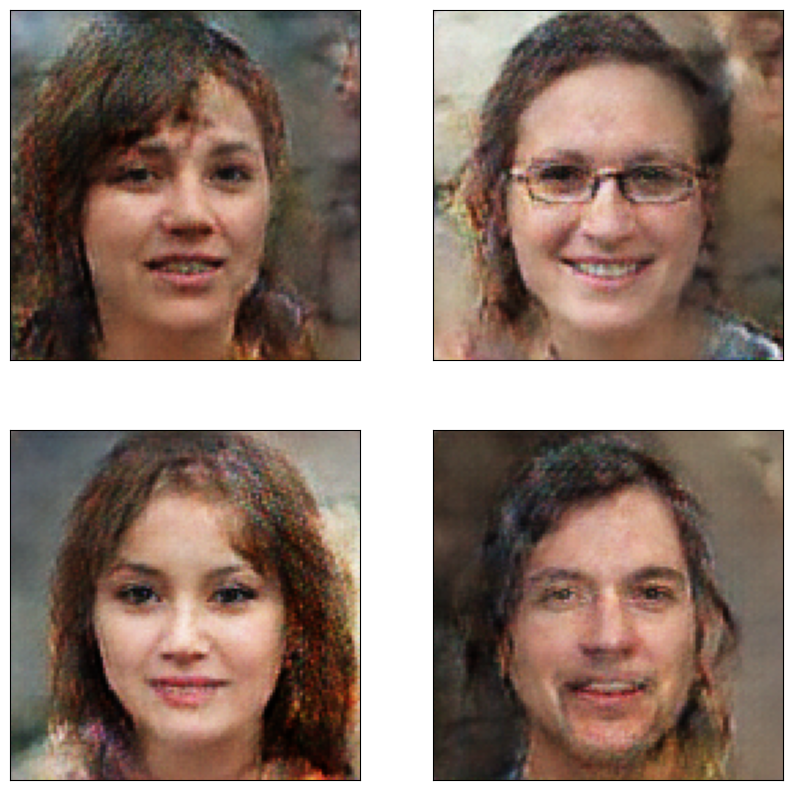

In [ ]:
# Generated the random images from the normal distribution noise
plot_generated_images(2)

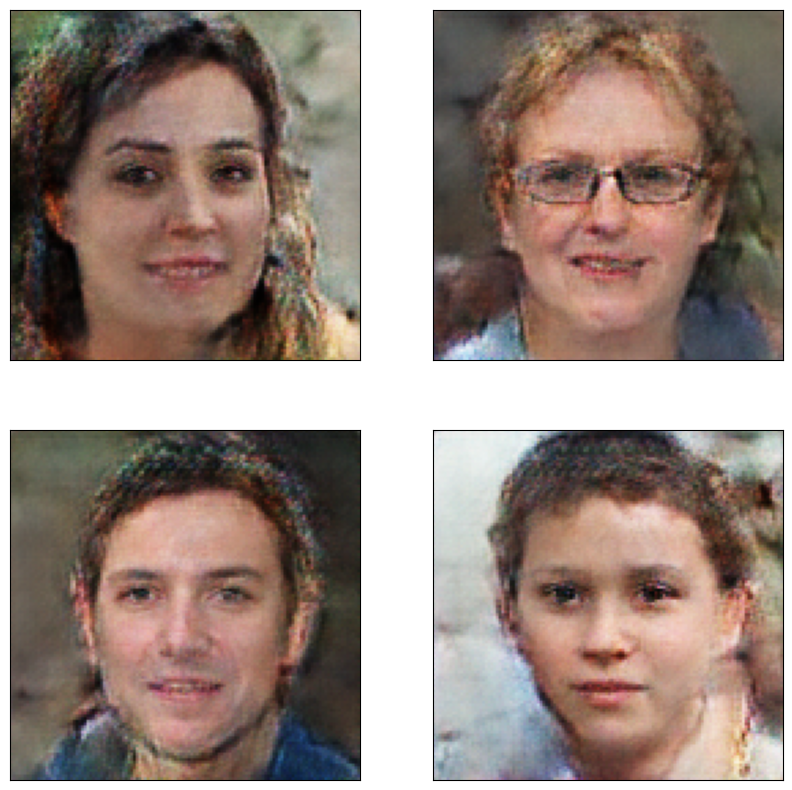

In [29]:
# Generated the random images from the normal distribution noise
plot_generated_images(2)

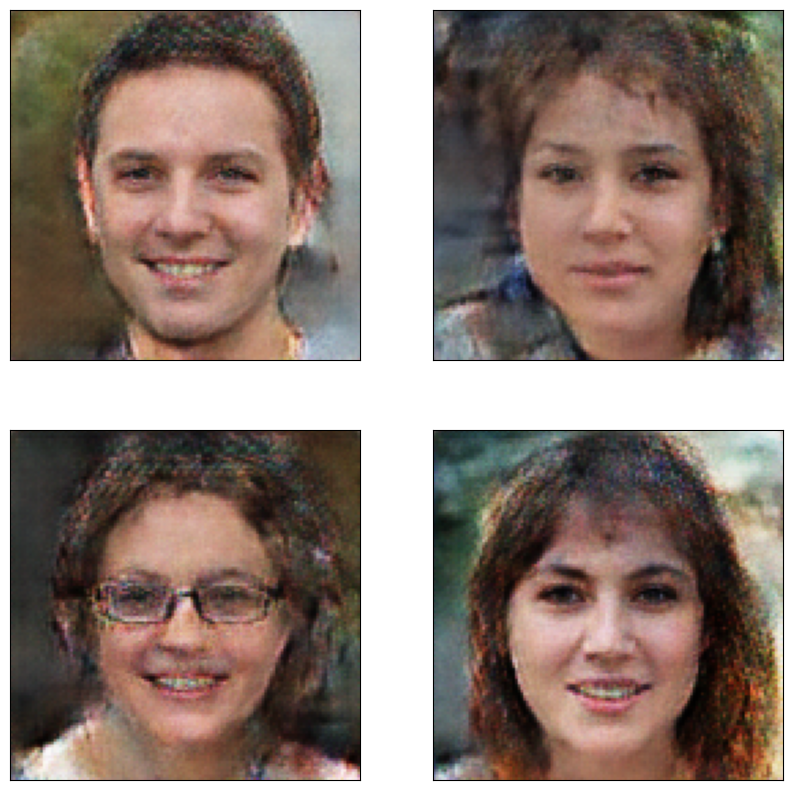

In [30]:
# Generated the random images from the normal distribution noise
plot_generated_images(2)

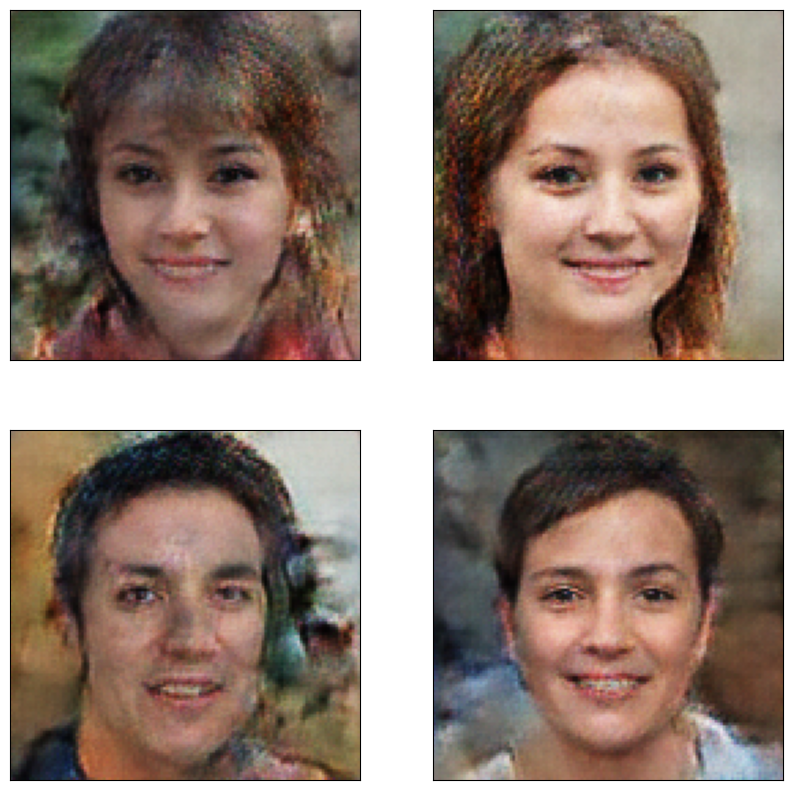

In [31]:
# Generated the random images from the normal distribution noise
plot_generated_images(2)

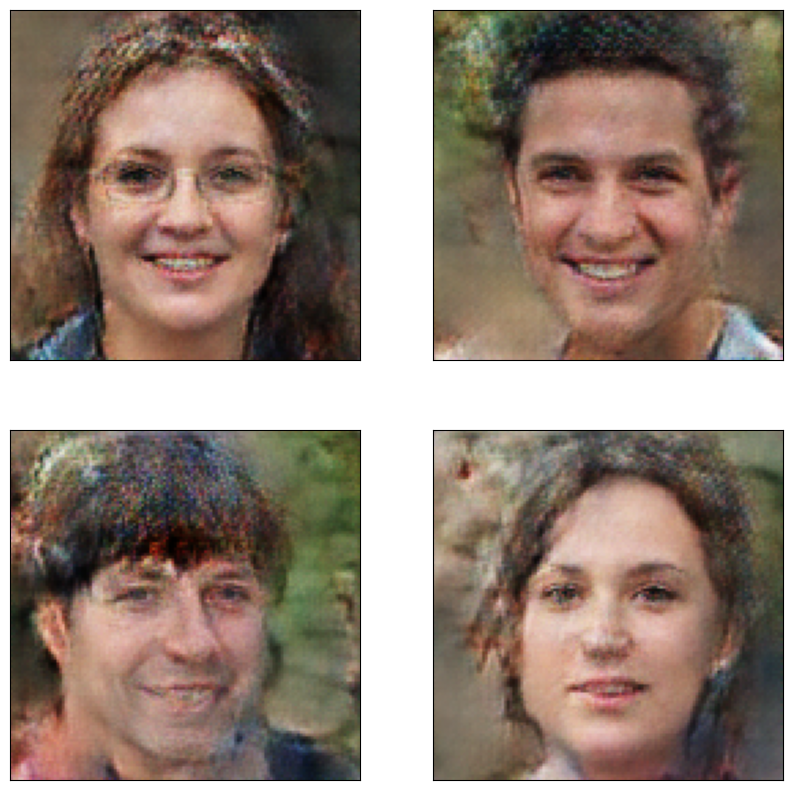

In [34]:
# Generated the random images from the normal distribution noise
plot_generated_images(2)

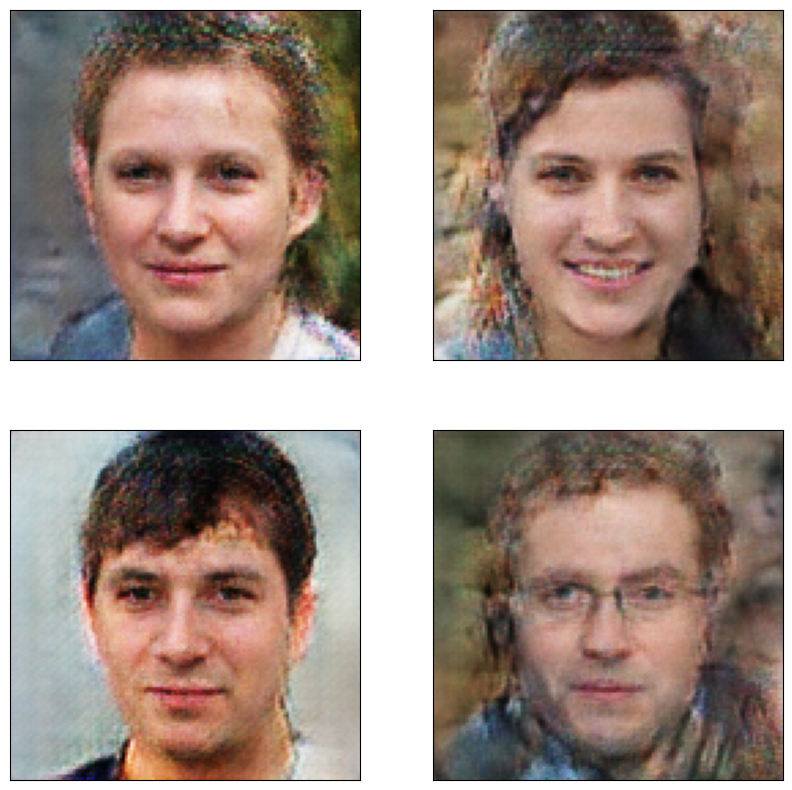

In [35]:
# Generated the random images from the normal distribution noise
plot_generated_images(2)

<h2>Showing 49 images generated by the random noise from the normal distribution</h2>

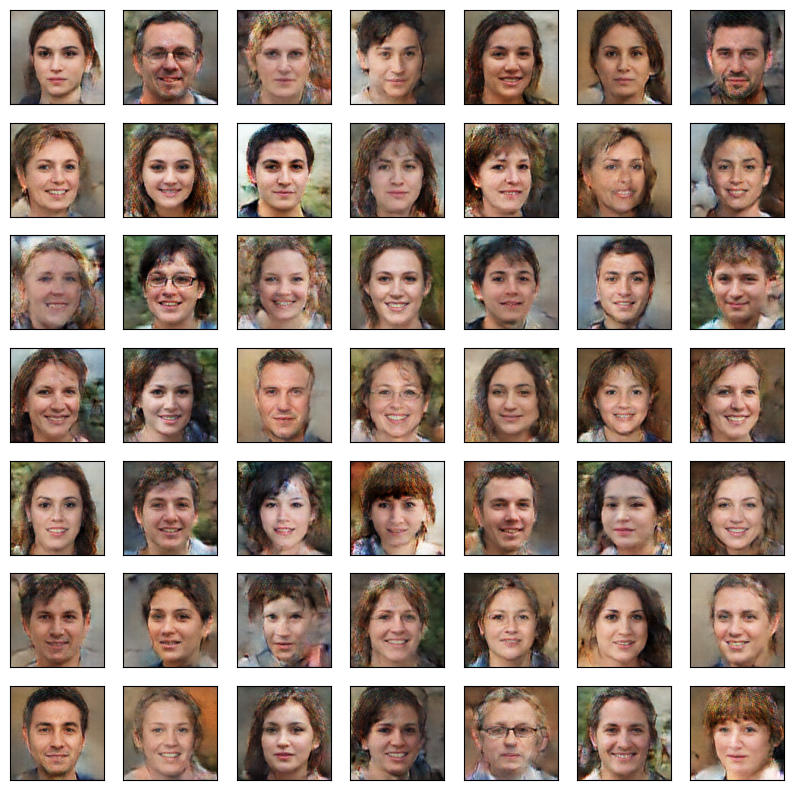

In [28]:
# Generated the random images from the normal distribution noise
plot_generated_images(7)

<h2>Plotting the loss of the genertor and discriminator</h2>

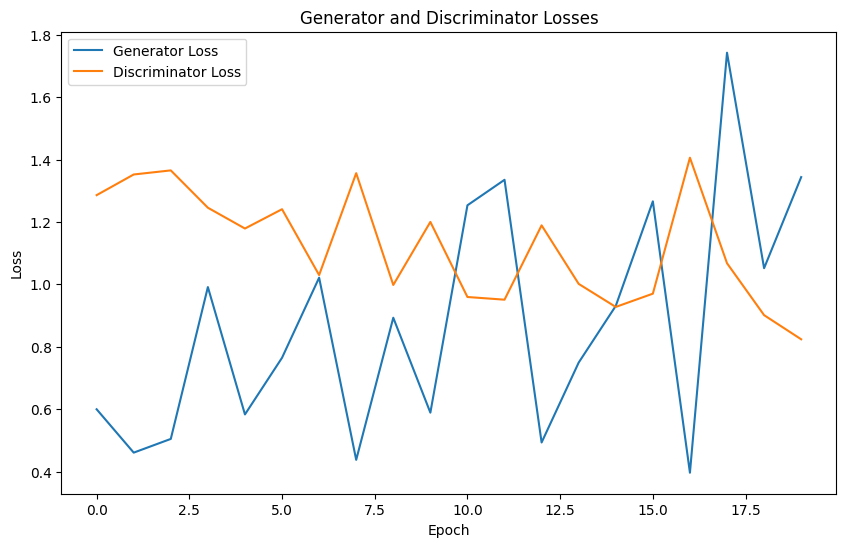

In [43]:
def plot_losses(history):
    """
    Plot generator and discriminator losses over epochs.

    Args:
        history (dict): Dictionary containing generator and discriminator losses for each epoch.
    """
    # Create a new figure for plotting
    plt.figure(figsize=(10, 6))
    
    # Plot generator loss over epochs
    plt.plot(history['gen_losses'], label='Generator Loss')
    
    # Plot discriminator loss over epochs
    plt.plot(history['disc_losses'], label='Discriminator Loss')
    
    # Add labels and title to the plot
    plt.xlabel('Epoch')  # X-axis label
    plt.ylabel('Loss')   # Y-axis label
    plt.title('Generator and Discriminator Losses')  # Plot title
    
    # Add legend to distinguish between generator and discriminator losses
    plt.legend()
    
    # Display the plot
    plt.show()
    
plot_losses(history)